## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

# Import time series data: Unemployment rate

In [2]:
data = pd.read_csv('UNRATE.csv', header = None)
data.columns = ['DATE','UNRATE']
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')
data = data.set_index('DATE')
data.head(13)

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


## Plot time series data

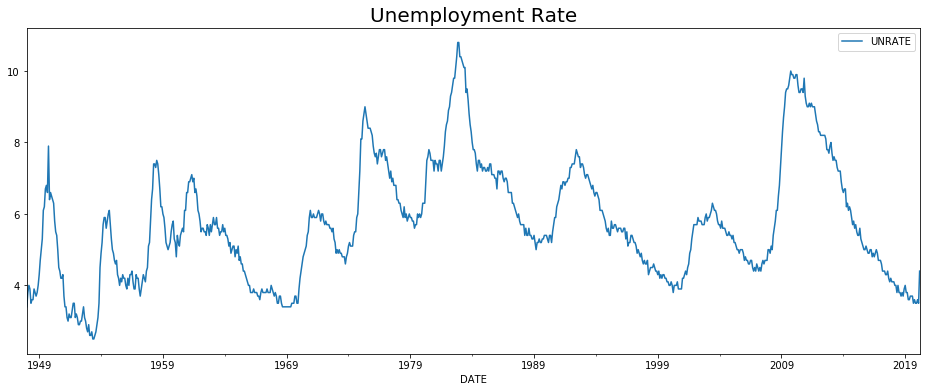

In [3]:
data.plot(figsize=(16, 6))
plt.legend(loc='best')
plt.title('Unemployment Rate', fontsize=20)
plt.show(block=False)

In [4]:
data.isnull().sum()   #there are no missing values

UNRATE    0
dtype: int64

## Split time series data into training and test set

In [5]:
train_len = 612
train = data[0:train_len] 
test = data[train_len:]
print(train)
print(test)

            UNRATE
DATE              
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5
...            ...
1998-08-01     4.5
1998-09-01     4.6
1998-10-01     4.5
1998-11-01     4.4
1998-12-01     4.4

[612 rows x 1 columns]
            UNRATE
DATE              
1999-01-01     4.3
1999-02-01     4.4
1999-03-01     4.2
1999-04-01     4.3
1999-05-01     4.2
...            ...
2019-11-01     3.5
2019-12-01     3.5
2020-01-01     3.6
2020-02-01     3.5
2020-03-01     4.4

[255 rows x 1 columns]


## Box Cox transformation

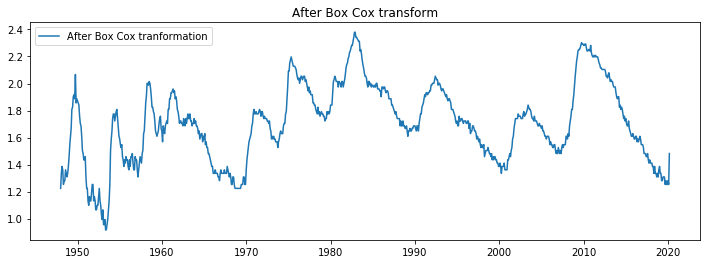

In [6]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['UNRATE'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

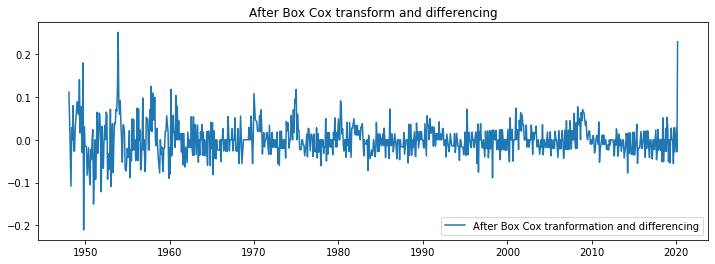

DATE
1948-01-01         NaN
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
                ...   
2019-11-01   -0.028171
2019-12-01    0.000000
2020-01-01    0.028171
2020-02-01   -0.028171
2020-03-01    0.228842
Length: 867, dtype: float64


In [7]:
#Differencing to remove trend
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

print(data_boxcox_diff)

In [8]:
data_boxcox_diff.dropna(inplace=True) #dropping the first empty row

## Create train and test of stationary series

In [9]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [10]:
train_data_boxcox_diff

DATE
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
1948-06-01    0.028171
                ...   
1998-08-01    0.000000
1998-09-01    0.021979
1998-10-01   -0.021979
1998-11-01   -0.022473
1998-12-01    0.000000
Length: 611, dtype: float64

## Auto regression method (AR)

In [11]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


## Recover original time series

In [12]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

# Plot train, test and forecast

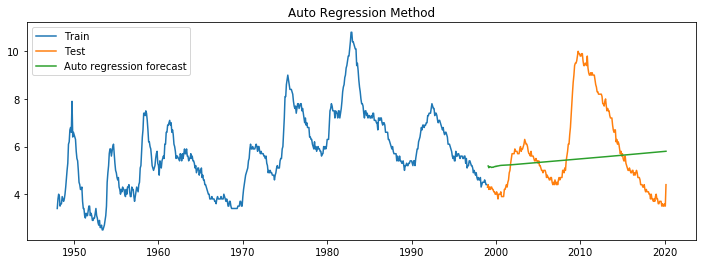

1948-02-01    3.901819
1948-03-01    3.960922
1948-04-01    4.082803
1948-05-01    4.188015
1948-06-01    4.210204
                ...   
2019-11-01    5.791572
2019-12-01    5.794274
2020-01-01    5.796976
2020-02-01    5.799680
2020-03-01    5.802386
Freq: MS, Length: 866, dtype: float64


In [13]:
plt.figure(figsize=(12,4))
plt.plot(data['UNRATE'][:train_len], label='Train')
plt.plot(data['UNRATE'][train_len:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][train_len:], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()


print(y_hat_ar['ar_forecast'])#To know the predicted value for the month of June 1948 

In [14]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ar['ar_forecast'][test.index.min():])/test['UNRATE'])*100,2)


results = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62


## Moving average method (MA)

In [15]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [16]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

1948-02-01    3.901980
1948-03-01    3.950280
1948-04-01    4.057868
1948-05-01    4.143129
1948-06-01    4.141527
                ...   
2019-11-01    5.921776
2019-12-01    5.924781
2020-01-01    5.927789
2020-02-01    5.930797
2020-03-01    5.933808
Freq: MS, Length: 866, dtype: float64


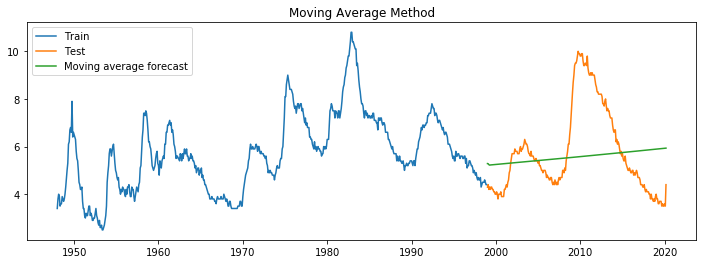

In [17]:
print(y_hat_ma['ma_forecast'])

plt.figure(figsize=(12,4))
plt.plot(data['UNRATE'][:train_len], label='Train')
plt.plot(data['UNRATE'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [18]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ma['ma_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26


## ARMA

In [19]:
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 5))
model_fit = model.fit()
print(model_fit.params)

C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000458
ar.L1.y    -0.220889
ar.L2.y     0.756848
ar.L3.y     0.553757
ar.L4.y    -0.506903
ar.L5.y    -0.654034
ar.L6.y     0.058309
ar.L7.y     0.050170
ar.L8.y     0.101922
ar.L9.y     0.159699
ar.L10.y   -0.046601
ar.L11.y   -0.025743
ar.L12.y   -0.050402
ma.L1.y     0.250318
ma.L2.y    -0.594492
ma.L3.y    -0.410138
ma.L4.y     0.560173
ma.L5.y     0.719714
dtype: float64


C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Recover original time series

In [20]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

## Plot train, test and forecast

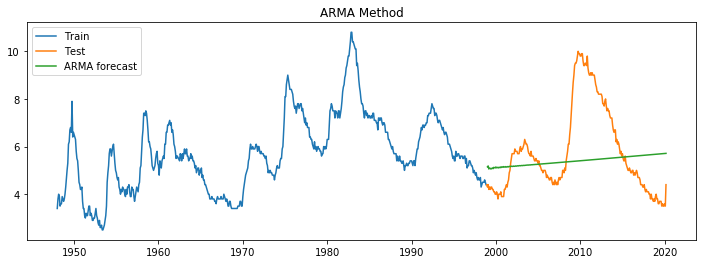

In [21]:
plt.figure(figsize=(12,4))
plt.plot( data['UNRATE'][:train_len-1], label='Train')
plt.plot(data['UNRATE'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [22]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_arma['arma_forecast'][train_len-1:])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive moving average (ARMA) method,1.85,23.23


## ARIMA

In [23]:
model = ARIMA(train_data_boxcox, order=(12, 1, 5))
model_fit = model.fit()
print(model_fit.params)

C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const         0.000458
ar.L1.D.y    -0.220889
ar.L2.D.y     0.756848
ar.L3.D.y     0.553757
ar.L4.D.y    -0.506903
ar.L5.D.y    -0.654034
ar.L6.D.y     0.058309
ar.L7.D.y     0.050170
ar.L8.D.y     0.101922
ar.L9.D.y     0.159699
ar.L10.D.y   -0.046601
ar.L11.D.y   -0.025743
ar.L12.D.y   -0.050402
ma.L1.D.y     0.250318
ma.L2.D.y    -0.594492
ma.L3.D.y    -0.410138
ma.L4.D.y     0.560173
ma.L5.D.y     0.719714
dtype: float64


C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Recover original time series

In [24]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

## Plot train, test and forecast

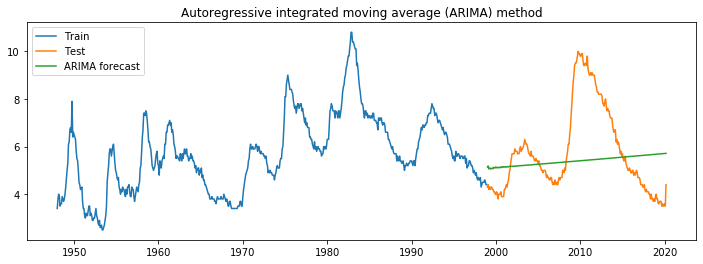

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### RMSE and MAPE

In [26]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_arima['arima_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive moving average (ARMA) method,1.85,23.23
0,Autoregressive integrated moving average (ARIM...,1.85,23.23


## SARIMA

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ajay.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ar.L1       0.598652
ar.L2       0.121533
ma.L1      -0.560886
ma.L2      -0.005359
ma.L3       0.068107
ma.L4       0.054699
ar.S.L12   -0.936120
ar.S.L24   -0.510952
ma.S.L12   -0.279394
ma.S.L24   -0.538431
ma.S.L36   -0.397994
ma.S.L48    0.269891
sigma2      0.001494
dtype: float64


In [28]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

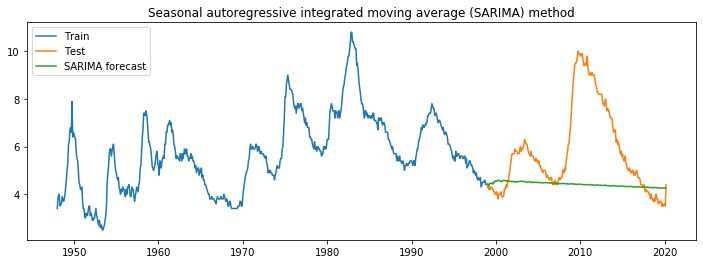

In [29]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [30]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['UNRATE'])*100,2)


tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive moving average (ARMA) method,1.85,23.23
0,Autoregressive integrated moving average (ARIM...,1.85,23.23
0,Seasonal autoregressive integrated moving aver...,2.26,22.17
